# some figures related to single-site emulator

In [1]:
import sys, os, glob, pickle, toml, json, pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def set_background(ax):
    ax.set_extent([-121, -72, 25, 50])

    # Background boundaries
    # ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray')
    
    return ax

In [2]:
# load info
infile_basin_info = f"/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv"
df_info = pd.read_csv(infile_basin_info)

In [3]:
# load data

path = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/LargeSampleEmulator_exps_out'

methods1 = ['gpr', 'rf', 'mlp']
methods2 = ['GPR', 'RF' , 'MLP']

cv_est = []

numbasin = 627
cv_eval = np.nan * np.zeros([numbasin, 5, 2, 2, 3]) # numbasin; 5 fold; rmse/cc; train/testl; gpr/rf/mlp

for i in range(3):

    file = f'{path}/SSE_{methods2[i]}_normKGE_CV_estimates.pkl'
    with open(file, 'rb') as file:
        cv_est.append( pickle.load(file) )

    file =  f'{path}/SSE_{methods2[i]}_normKGE_CV_evaluation.npz'
    dtmp = np.load(file)
    cv_eval[:,:,0,0,i] = dtmp[f'{methods1[i]}_rmse_train']
    cv_eval[:,:,0,1,i] = dtmp[f'{methods1[i]}_rmse_test']
    cv_eval[:,:,1,0,i] = dtmp[f'{methods1[i]}_cc_train']
    cv_eval[:,:,1,1,i] = dtmp[f'{methods1[i]}_cc_test']


# plot the scatter plot of one basin with mean kge

In [4]:
d = np.mean( cv_eval[:,:,0,1,0], axis=1)
usebasin = np.argmin( np.abs(d - np.mean(d)))
print(usebasin)

105


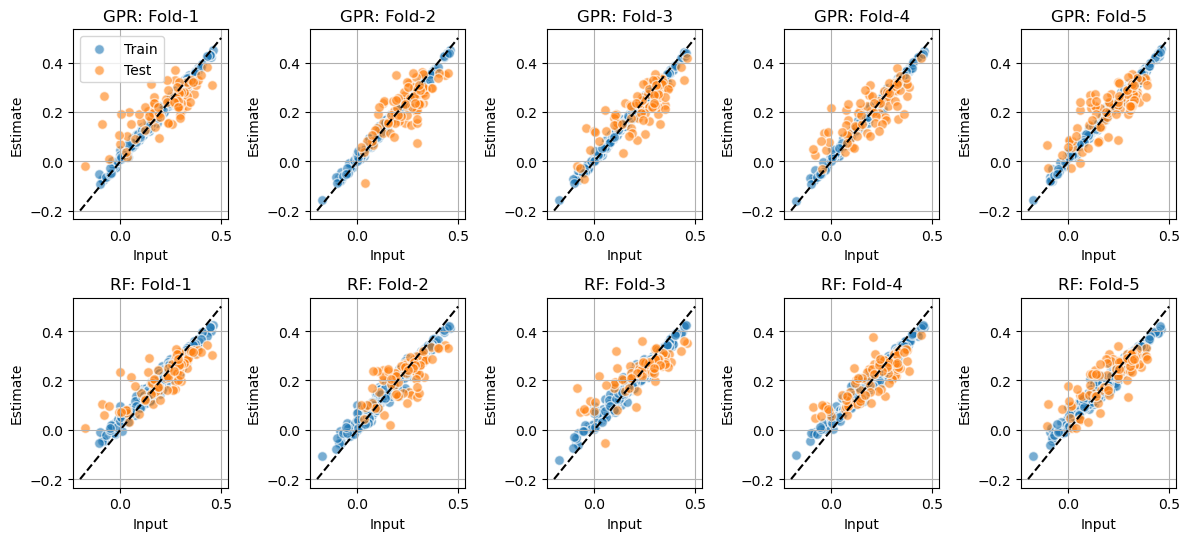

In [5]:
fig, axs = plt.subplots(2, 5, figsize=(12, 6))

for i in range(1, 6):
    cvi_gpr = cv_est[0][usebasin]
    cvi_rf = cv_est[1][usebasin]

    # GPR plots
    ax = axs[0, i-1]
    ax.scatter(cvi_gpr[i]['y_train'], cvi_gpr[i]['y_train_pred'], label='Train', alpha=0.6, edgecolors='w', s=50)
    ax.scatter(cvi_gpr[i]['y_test'], cvi_gpr[i]['y_test_pred'], label='Test', alpha=0.6, edgecolors='w', s=50)
    ax.plot([-0.2, 0.5], [-0.2, 0.5], color='k', linestyle='--')
    ax.set_xlabel('Input')
    ax.set_ylabel('Estimate')
    ax.set_title(f'GPR: Fold-{i}')
    ax.grid(True)

    if i == 1:
        ax.legend()

    # RF plots
    ax = axs[1, i-1]
    ax.scatter(cvi_rf[i]['y_train'], cvi_rf[i]['y_train_pred'], label='Train', alpha=0.6, edgecolors='w', s=50)
    ax.scatter(cvi_rf[i]['y_test'], cvi_rf[i]['y_test_pred'], label='Test', alpha=0.6, edgecolors='w', s=50)
    ax.plot([-0.2, 0.5], [-0.2, 0.5], color='k', linestyle='--')
    ax.set_xlabel('Input')
    ax.set_ylabel('Estimate')
    ax.set_title(f'RF: Fold-{i}')
    ax.grid(True)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig('SSE_examplebasin_CV_scatter.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

# compare GPR and Random Forest

In [6]:
lat = df_info['lat_cen'].values
lon = df_info['lon_cen'].values


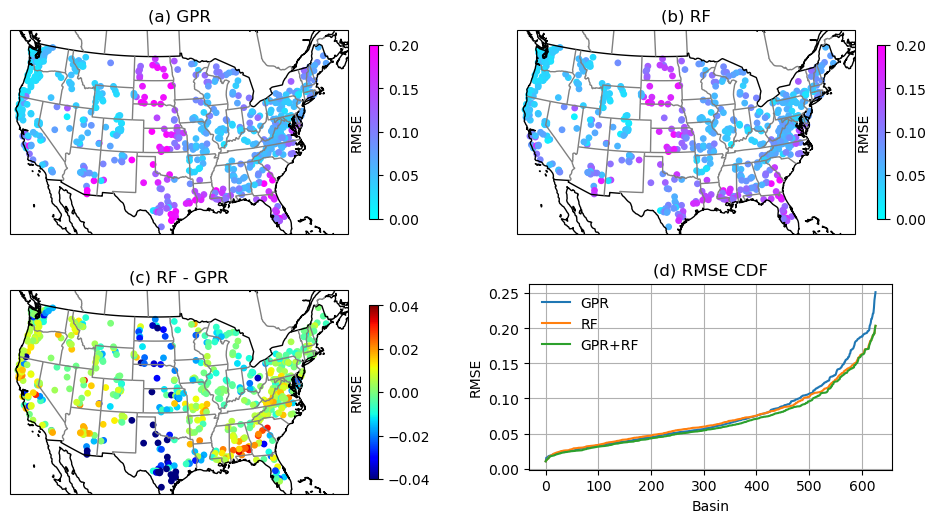

In [7]:
# plot rmse
m1 = np.mean(cv_eval[:,:,0,1,0], axis=1)
m2 = np.mean(cv_eval[:,:,0,1,1], axis=1)
m3 = m2-m1
m4 = np.minimum(m1, m2)
data = [m1, m2, m3]

title = ["(a) GPR", "(b) RF", "(c) RF - GPR", ]
cmaps = ['cool', 'cool', 'jet']
lims = [ [0, 0.2], [0, 0.2], [-0.04, 0.04]]

# font = {'size'   : 12}
# matplotlib.rc('font', **font)

fig = plt.figure(figsize=[12, 6.2])

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()


for i in range(3):
    ax = fig.add_subplot(2, 2, i+1, projection=proj)
    ax = set_background(ax)
    p = ax.scatter(lon, lat, 15, data[i], cmap=cmaps[i], vmin=lims[i][0], vmax=lims[i][1], transform=transf)
    ax.set_title(title[i])
    
    cax = plt.colorbar(p, ax=ax, location='right', shrink=0.8, label='RMSE')
    cax.ax.yaxis.set_ticks_position('right')
    cax.ax.yaxis.set_label_position('left')
    # ax.spines['geo'].set_visible(False)


ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(np.sort(m1), label='GPR')
ax4.plot(np.sort(m2), label='RF')
ax4.plot(np.sort(m4), label='GPR+RF')
ax4.set_xlabel('Basin')
ax4.set_ylabel('RMSE')
ax4.legend(frameon=False)
ax4.grid('on')
ax4.set_title("(d) RMSE CDF")

pos = list(ax4.get_position().bounds)
pos[3] = pos[3] - 0.05
pos[2] = pos[2] - 0.05
pos[1] = pos[1] + 0.05
pos[0] = pos[0] + 0.01

ax4.set_position(pos)

# plt.tight_layout()
# plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)

plt.savefig('SSE_RF_GPR_CV_RMSE_map.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

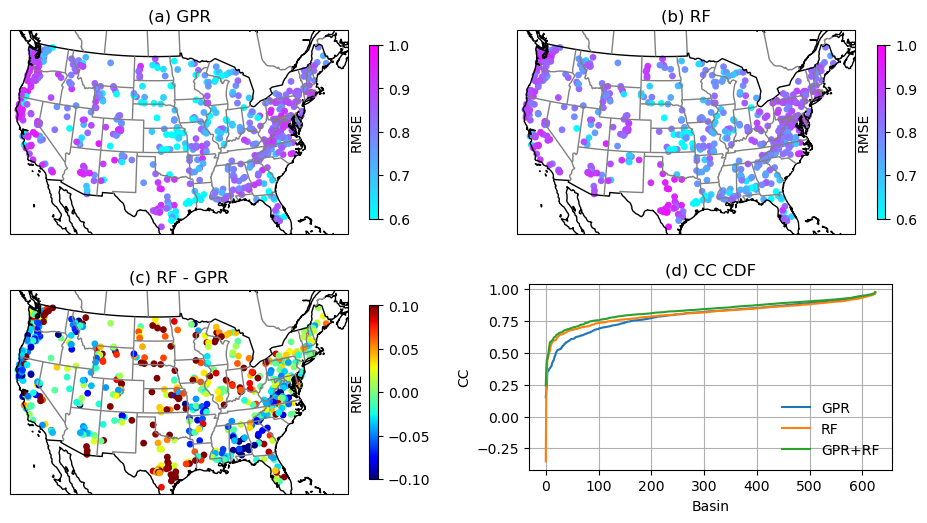

In [8]:
# plot cc
m1 = np.mean(cv_eval[:,:,1,1,0], axis=1)
m2 = np.mean(cv_eval[:,:,1,1,1], axis=1)
m3 = m2-m1
m4 = np.maximum(m1, m2)
data = [m1, m2, m3]

title = ["(a) GPR", "(b) RF", "(c) RF - GPR", ]
cmaps = ['cool', 'cool', 'jet']
lims = [ [0.6, 1], [0.6, 1], [-0.1, 0.1]]

# font = {'size'   : 12}
# matplotlib.rc('font', **font)

fig = plt.figure(figsize=[12, 6.2])

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()


for i in range(3):
    ax = fig.add_subplot(2, 2, i+1, projection=proj)
    ax = set_background(ax)
    p = ax.scatter(lon, lat, 15, data[i], cmap=cmaps[i], vmin=lims[i][0], vmax=lims[i][1], transform=transf)
    ax.set_title(title[i])
    
    cax = plt.colorbar(p, ax=ax, location='right', shrink=0.8, label='RMSE')
    cax.ax.yaxis.set_ticks_position('right')
    cax.ax.yaxis.set_label_position('left')
    # ax.spines['geo'].set_visible(False)


ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(np.sort(m1), label='GPR')
ax4.plot(np.sort(m2), label='RF')
ax4.plot(np.sort(m4), label='GPR+RF')
ax4.set_xlabel('Basin')
ax4.set_ylabel('CC')
ax4.legend(frameon=False)
ax4.grid('on')
ax4.set_title("(d) CC CDF")

pos = list(ax4.get_position().bounds)
pos[3] = pos[3] - 0.05
pos[2] = pos[2] - 0.05
pos[1] = pos[1] + 0.05
pos[0] = pos[0] + 0.01

ax4.set_position(pos)

# plt.tight_layout()
# plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)

plt.savefig('SSE_RF_GPR_CV_CC_map.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

# Compare training and testing periods
Overfitting is a problem, but we care more about the performance in the testing period instead the difference

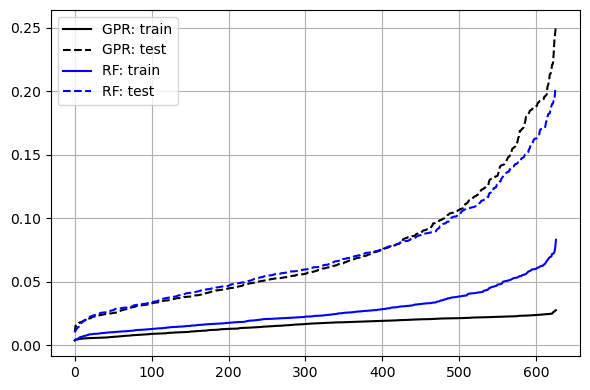

In [9]:
method = ['GPR','RF','MLP']
c = ['k', 'b', 'r']

fig = plt.figure(figsize=[6, 4])

for i in range(2):
    m1 = np.mean(cv_eval[:,:,0,0,i], axis=1)
    m2 = np.mean(cv_eval[:,:,0,1,i], axis=1)
    plt.plot(np.sort(m1), '-', color=c[i], label=f'{method[i]}: train')
    plt.plot(np.sort(m2), '--', color=c[i], label=f'{method[i]}: test')

plt.grid('on')
plt.legend()
plt.tight_layout()
plt.savefig('SSE_GPRandRF_traintest_CDF.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()